In [31]:
import torch 
import torch.nn.functional as F 
import matplotlib.pyplot as plt 
%matplotlib inline 

In [32]:
words = names = open("names.txt").read().splitlines() 
chars = sorted(list(set("".join(words))))
stoi = dict(zip(["."]+chars, range(27)))
itos = {v:k for k, v in stoi.items()}
N_CHARS = len(stoi )


N_EMB = 2
N_CONTEXT = 3

def build_dataset(tokens):
    X, Y = [], []
    TERMINAL = "." 

    for word in tokens: 
        # print(word)
        context = [0] * N_CONTEXT
        for ch in word + TERMINAL: 
            X.append(list(context))
            Y.append(stoi[ch])
            # print("".join([itos[ix] for ix in XS[-1]])+ f" ---> {ch}")
            context = (context + [stoi[ch]])[-3:]
        
    return torch.tensor(X), torch.tensor(Y)

import random 
random.seed(42)
random.shuffle(words)
n1 = int(.8 * len(words))
n2 = int(.9 * len(words))

Xtrain, Ytrain = build_dataset(words[:n1])
Xvalid, Yvalid = build_dataset(words[n1:n2])
Xtest, Ytest  = build_dataset(words[n2:])

print("Total Contexts: ", Xtrain.shape[0] + Xvalid.shape[0] + Xtest.shape[0])



Total Contexts:  228146


In [36]:
# Prepare Network Architecture 

g = torch.Generator().manual_seed(2147483647)

Emb = torch.rand(N_CHARS, N_EMB, requires_grad=True, generator=g)
W1 = torch.randn(N_CONTEXT * N_EMB, 100, requires_grad=True, generator=g)
b1 = torch.randn(100, requires_grad=True, generator=g)
W2 = torch.randn(100, N_CHARS, requires_grad=True, generator=g)
b2 = torch.randn(N_CHARS, requires_grad=True, generator=g)

parameters = [Emb, W1, b1, W2, b2]


In [68]:
import torch.nn.functional as F 

def forward_pass(X):
    XEmb = Emb[X].view(-1, N_CONTEXT * N_EMB)
    L1_Activations = torch.tanh((XEmb @ W1 + b1)) 
    logits  = (L1_Activations @ W2) + b2 
    return logits 

def calculate_loss(logits, Y): 
    """
    calculating negative loss likelihood loss)
    """
    return F.cross_entropy(logits, target=Y) 


def backward_pass(loss):
    for param in parameters:
        param.grad = None 
    loss.backward() 
    for param in parameters:
        param.data += (-0.01 * param.grad)

iters = 1000
losses = [] 

for i in range(iters): 
    # Make mini batch Batch
    # batchidxs = torch.rand(0, Xtrain.shape[0], size=(32,)) 
    batchidxs = torch.randint(0, Xtrain.shape[0], (32,))
    
    # Forward Pass 
    probs = forward_pass(Xtrain[batchidxs])

    #Loss Calculation  
    loss = calculate_loss(probs, Ytrain[batchidxs])
    losses.append(loss.item())  

    #Backward Pass  
    backward_pass(loss)

logits = forward_pass(Xtest)
testloss = calculate_loss(logits, Ytest)

print(losses[-1], testloss.item())

# plt.plot(torch.arange(len(losses)), losses)


2.484097480773926 2.3833248615264893


In [ ]:
# Sample 10 strings from the model 
g = torch.Generator().manual_seed(2147483647)
for _ in range(1):
    context = [0] * CONTEXT_SIZE 
    chars = []
    while True: 
        x = Emb[torch.tensor(context)].view(1, 6)
        probs = forward_pass(x)
        print(probs)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        print(ix)
        chars.append(itos[ix])
        if ix == 0: 
            break
        context = context[1:] + [ix]
         
    # print("".join(chars))

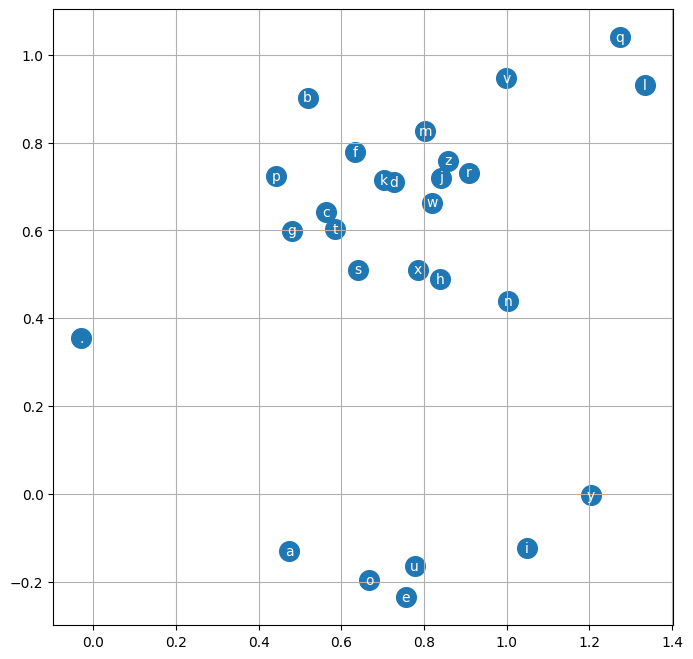

In [70]:
# visualize dimensions 0 and 1 of the embedding matrix C for all characters
C = Emb 
plt.figure(figsize=(8,8))
plt.scatter(C[:,0].data, C[:,1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
plt.grid('minor')